In [1]:
%pylab inline


Bad key "text.kerning_factor" on line 4 in
/home/harryem/anaconda3/envs/bats_p37/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams
import tadasets
import time
from scipy.spatial.distance import pdist, squareform

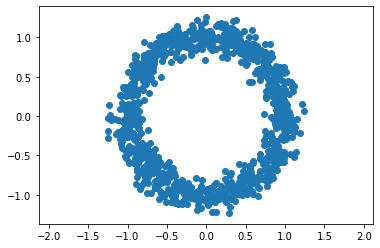

In [3]:
np.random.seed(9)
x = tadasets.dsphere(n=1000, d=1, noise=0.1)

plt.scatter(x[:, 0], x[:, 1])
plt.axis('equal')
plt.show()

In [4]:
D = pdist(x, 'euclidean')
D = squareform(D)

In [5]:
btime = time.time()
result = ripser(x, coeff=2, do_cocycles=True)
etime = time.time()
pc_time = etime - btime
print('pointcloud: {} sec.'.format(pc_time))

pointcloud: 9.525873899459839 sec.


In [6]:
btime = time.time()
result = ripser(D, coeff=2, do_cocycles=True, distance_matrix=True)
etime = time.time()
d_time = etime - btime
print('distance matrix: {} sec.'.format(d_time))

distance matrix: 11.94050121307373 sec.


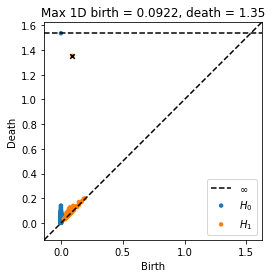

In [7]:
diagrams = result['dgms']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

We want to create a diagram

$Rips(D2, r0) \subseteq Rips(D1, r) \subseteq Rips(D2, r1)$

In [14]:
thresh = 0.5
D1 = squareform(pdist(x, 'euclidean'))
D2 = squareform(pdist(x, 'cityblock'))

In [15]:
np.max(D2[D1 <= thresh])

0.706901711708581

In [18]:
def get_thresh_in(D1, D2, thresh):
    """
    Find maximum thresh2 so Rips(D2, thresh2) is contained in Rips(D1, thresh)
    
    Inputs:
        D1 : distance matrix (square or condensed)
        D2 : distance matrix (square or condensed)
        thresh: threshold for rips complex built on D1
        
    Returns:
        thresh2: threshold for rips complex built on D1
    """  
    D1 = D1.flatten()
    D2 = D2.flatten()
    
    thresh2 = np.inf
    for d1, d2 in zip(D1, D2):
        if d1 > thresh and d2 <= thresh2:
            thresh2 = d2 - np.finfo(float).eps
    return thresh2

In [16]:
def get_thresh_out(D1, D2, thresh):
    """
    Find minimum thresh2 so Rips(D1, thresh) is contained in Rips(D2, thresh2)
    
    Inputs:
        D1 : distance matrix (square or condensed)
        D2 : distance matrix (square or condensed)
        thresh: threshold for rips complex built on D1
        
    Returns:
        thresh2: threshold for rips complex built on D1
    """  
    return np.max(D2[D1 <= thresh])

In [51]:
def get_inclusion_rips(D1, D2, r):
    """
    Construct a filtration on edges so
    Rips(D2, r0) \subseteq Rips(D1, r) \subseteq Rips(D2, r1)
    
    edges in Rips(D2, r0) appear at time 1
    edges in Rips(D1, r )  appear at time 2
    edges in Rips(D2, r1) appear at time 3
    all other edges appear at 4
    
    Inputs:
        D1 : distance matrix (square or condensed)
        D2 : distance matrix (square or condensed)
        r : threshold for rips complex built on D1
        
    Returns:
        D3: distance matrix specifying inclusion relations
    """
    r0 = get_thresh_in(D1, D2, r)
    r1 = get_thresh_out(D1, D2, r)
    dshape = D1.shape
    D1 = D1.flatten()
    D2 = D2.flatten()
    
    D3 = np.empty(D1.shape, dtype=np.float)
    for i, (d1, d2) in enumerate(zip(D1, D2)):
        if d2 <= r0:
            D3[i] = 1
        elif d1 <= r:
            D3[i] = 2
        elif d2 <= r1:
            D3[i] = 3
        else:
            D3[i] = 4
            
    return D3.reshape(*dshape)

In [76]:
D3 = get_inclusion_rips(D1, D2, 0.5)

In [77]:
btime = time.time()
result = ripser(D3, coeff=2, do_cocycles=True, distance_matrix=True)
etime = time.time()
d_time = etime - btime
print('distance matrix: {} sec.'.format(d_time))

distance matrix: 2.658149003982544 sec.


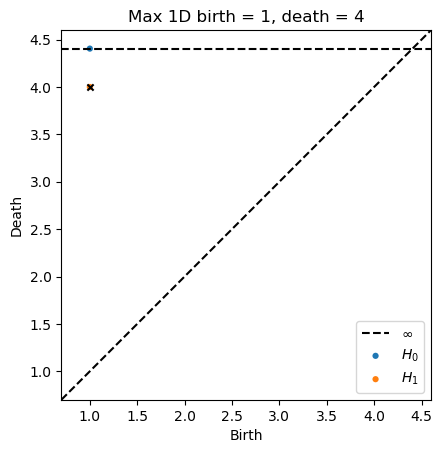

In [78]:
diagrams = result['dgms']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

Here are some experiments with sparse matrices... don't really seem to work with Ripser yet.

In [58]:
?ripser

In [59]:
import scipy.sparse

In [72]:
D3[D3 == 4] = 0
D3s = scipy.sparse.csr_matrix(D3)

In [73]:
D3s

<1000x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 175354 stored elements in Compressed Sparse Row format>

In [74]:
btime = time.time()
result = ripser(D3s, coeff=2, do_cocycles=True, distance_matrix=True)
etime = time.time()
d_time = etime - btime
print('sparse distance matrix: {} sec.'.format(d_time))

sparse distance matrix: 0.26553773880004883 sec.


/home/brad/miniconda3/envs/bats/lib/python3.7/site-packages/persim/visuals.py:165: UserWarning: Attempting to set identical left == right == 1.0 results in singular transformations; automatically expanding.
  ax.set_xlim([x_down, x_up])
/home/brad/miniconda3/envs/bats/lib/python3.7/site-packages/persim/visuals.py:166: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  ax.set_ylim([y_down, y_up])


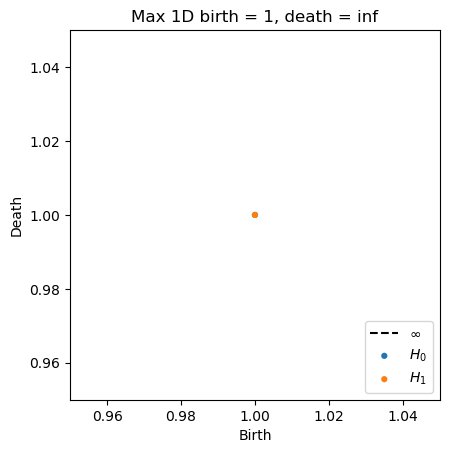

In [75]:
diagrams = result['dgms']
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

## Hausdorff Distance

In [8]:
from scipy.spatial.distance import directed_hausdorff
u = np.array([(1.0, 0.0),
              (0.0, 1.0),
              (-1.0, 0.0),
              (0.0, -1.0)])
v = np.array([(2.0, 0.0),
              (0.0, 2.0),
              (-2.0, 0.0),
              (0.0, -4.0)])

In [9]:
HD = directed_hausdorff(u, v)

In [10]:
HD

(2.23606797749979, 3, 0)

In [11]:
u

array([[ 1.,  0.],
       [ 0.,  1.],
       [-1.,  0.],
       [ 0., -1.]])

In [12]:
v

array([[ 2.,  0.],
       [ 0.,  2.],
       [-2.,  0.],
       [ 0., -4.]])

In [13]:
? directed_hausdorff

In [29]:
# gt_matrix = np.load('/home/harryem/data/HimalGen/gt_matrix.npy')
# gt_matrix_PCs = np.load('/home/harryem/data/HimalGen/gt_matrix_PCs.npy')
# gt_matrix_PCs_50 = np.load('/home/harryem/data/HimalGen/gt_matrix_PCs_50.npy')
gt_matrix_PCs_2 = np.load('/home/harryem/data/HimalGen/gt_matrix_PCs_2.npy').T
print(gt_matrix_PCs_2.shape)

(5496, 2)


In [46]:
LOO_Haus_dist = []

for i in range(gt_matrix_PCs_2.shape[0]):

    D0 = directed_hausdorff(np.expand_dims(gt_matrix_PCs_2[i], axis=0), np.delete(gt_matrix_PCs_2, i, 0))
    LOO_Haus_dist.append(D0[0])

In [47]:
LOO_Haus_dist

[0.04045301247214843,
 0.10504129854536291,
 0.03930490136185808,
 0.2556943587551828,
 0.07428753113387347,
 0.09992945485424158,
 0.06049243557109771,
 0.056522895883974925,
 0.17794452469199304,
 0.4549511388768269,
 0.03171286814927978,
 0.03811404625137468,
 0.0955412851677289,
 0.045369342214332406,
 0.10273224546264999,
 0.08288752058579933,
 0.1444026967181154,
 0.20754953884451366,
 0.20283703691694635,
 0.05998800483963661,
 0.18245491849753429,
 0.2275332808924188,
 0.0331489047229159,
 0.03644403571645769,
 0.07941973673955216,
 0.07284169835110856,
 0.7545701067525561,
 0.6921566113265568,
 0.07918427058834827,
 0.07778393462452107,
 0.30068598045023615,
 0.14706169720971246,
 0.09015468158213252,
 0.03376447767385522,
 0.238767938982578,
 0.26142454584431113,
 0.21831424819149514,
 0.12715955587867975,
 0.07323143480888296,
 0.030734203927303395,
 0.05139228609994282,
 0.007654838869594931,
 0.21287282838204838,
 0.47069697401015875,
 0.036872507622967364,
 0.124420405941

In [26]:
distances = d.PairwiseDistances(points)

NameError: name 'd' is not defined

In [41]:
np.delete(gt_matrix_PCs_2, 0, 0)

array([[-18.723125  ,  10.84743   ],
       [ -9.345792  ,   8.883346  ],
       [ -9.121344  ,   9.150197  ],
       ...,
       [ 33.99224   ,  -0.16257808],
       [ 32.116604  ,  -0.62010324],
       [ 31.266922  ,   0.20793405]], dtype=float32)

In [40]:
gt_matrix_PCs_2

array([[-18.723125  ,  10.84743   ],
       [-16.861727  ,  13.065866  ],
       [ -9.345792  ,   8.883346  ],
       ...,
       [ 33.99224   ,  -0.16257808],
       [ 32.116604  ,  -0.62010324],
       [ 31.266922  ,   0.20793405]], dtype=float32)

In [54]:
# needed imports
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np

In [65]:
X = gt_matrix_PCs_2.astype(np.float64)
print(X.shape)
# generate the linkage matrix
Z = linkage(X, 'ward')

(5496, 2)


In [66]:
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

c, coph_dists = cophenet(Z, pdist(X))
c

0.9147167546906643

In [70]:
from scipy.cluster.hierarchy import fcluster
k=200
clusters = fcluster(Z, k, criterion='maxclust')

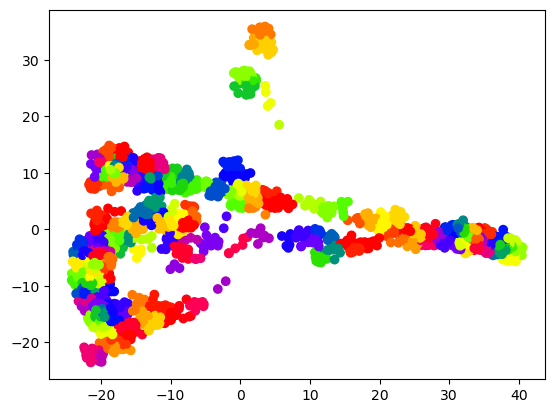

In [71]:

# plt.figure(figsize=(10, 8))
plt.scatter(X[:,0], X[:,1], c=clusters, cmap='prism')  # plot points with cluster dependent colors
plt.show()

In [75]:
clusters

array([140, 154, 183, ...,  43,  49,  51], dtype=int32)

In [76]:
from sklearn.cluster import AgglomerativeClustering

In [77]:
clustering = AgglomerativeClustering(200).fit(X)

In [81]:
dir(clustering)
clustering.get_params()

{'affinity': 'euclidean',
 'compute_full_tree': 'auto',
 'connectivity': None,
 'distance_threshold': None,
 'linkage': 'ward',
 'memory': None,
 'n_clusters': 200}